In [1]:
from pyspark.sql import SparkSession


spark = SparkSession.builder.appName("upload_data").getOrCreate()


df = spark.read.csv("/ProjectTweets.csv", header=False, inferSchema=True)



In [2]:

df.show()

+---+----------+--------------------+--------+---------------+--------------------+
|_c0|       _c1|                 _c2|     _c3|            _c4|                 _c5|
+---+----------+--------------------+--------+---------------+--------------------+
|  0|1467810369|Mon Apr 06 22:19:...|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|
|  1|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...|
|  2|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...|
|  3|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...|
|  4|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|@nationwideclass ...|
|  5|1467811372|Mon Apr 06 22:20:...|NO_QUERY|       joy_wolf|@Kwesidei not the...|
|  6|1467811592|Mon Apr 06 22:20:...|NO_QUERY|        mybirch|         Need a hug |
|  7|1467811594|Mon Apr 06 22:20:...|NO_QUERY|           coZZ|@LOLTrish hey  lo...|
|  8|1467811795|Mon Apr 06 22:20:...|NO_QUERY|2Hood4Hollywood|@Tatiana_K nop

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit

# Spark session start
spark = SparkSession.builder.appName("AddHeaderToDataFrame").getOrCreate()

columns = ["number", "id", "date", "query", "username", "text"]



# Header row
header = ("number", "id", "date", "query", "username", "text")

# Adding header row
df = df.toDF(*header)


df.show()

+------+----------+--------------------+--------+---------------+--------------------+
|number|        id|                date|   query|       username|                text|
+------+----------+--------------------+--------+---------------+--------------------+
|     0|1467810369|Mon Apr 06 22:19:...|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|
|     1|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...|
|     2|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...|
|     3|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...|
|     4|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|@nationwideclass ...|
|     5|1467811372|Mon Apr 06 22:20:...|NO_QUERY|       joy_wolf|@Kwesidei not the...|
|     6|1467811592|Mon Apr 06 22:20:...|NO_QUERY|        mybirch|         Need a hug |
|     7|1467811594|Mon Apr 06 22:20:...|NO_QUERY|           coZZ|@LOLTrish hey  lo...|
|     8|1467811795|Mon Apr 06 22:20:...|NO_

In [4]:

df.printSchema()



root
 |-- number: integer (nullable = true)
 |-- id: long (nullable = true)
 |-- date: string (nullable = true)
 |-- query: string (nullable = true)
 |-- username: string (nullable = true)
 |-- text: string (nullable = true)



In [5]:
print(f"There are {df.count()} rows and  {len(df.columns)} columns in the dataset.")

There are 1600000 rows and  6 columns in the dataset.


In [6]:
# Missing values check

from pyspark.sql import functions as func

df.select([func.count(func.when(func.isnan(c),c)).alias(c) for c in df.columns]).toPandas().head()

,number,id,date,query,username,text
0,0,0,0,0,0,0


In [7]:
# Duplicates check

df = df.dropDuplicates()
print(f"Number of rows in the dataframe after dropping the duplicates: {df.count()}")

Number of rows in the dataframe after dropping the duplicates: 1600000


In [8]:
#  Column types

df.dtypes


[('number', 'int'),
 ('id', 'bigint'),
 ('date', 'string'),
 ('query', 'string'),
 ('username', 'string'),
 ('text', 'string')]

In [9]:
drop_cols= ("id","query","username")
df = df.drop(*drop_cols)

In [10]:
df.printSchema()


root
 |-- number: integer (nullable = true)
 |-- date: string (nullable = true)
 |-- text: string (nullable = true)



In [11]:
df.show(5, truncate = False)

+------+----------------------------+---------------------------------------------------------------------------------------------------------------------------------------------+
|number|date                        |text                                                                                                                                         |
+------+----------------------------+---------------------------------------------------------------------------------------------------------------------------------------------+
|179   |Mon Apr 06 22:31:57 PDT 2009|Staying at a friends house...house sitting, neighbors are SO loud-having a party                                                             |
|668   |Mon Apr 06 23:06:23 PDT 2009|i dont want to believe what im reading...buu,so sad                                                                                          |
|747   |Mon Apr 06 23:11:06 PDT 2009|Have an invite for &quot;Healthy Dining&quot; session at Ashok 

In [12]:
print(f"There are {df.count()} rows and  {len(df.columns)} columns in the dataset.")

There are 1600000 rows and  3 columns in the dataset.


In [13]:
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer
import re

In [14]:
nltk.download('stopwords')
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")
text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

[nltk_data] Downloading package stopwords to /home/hduser/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [16]:
from pyspark.sql.types import StringType,FloatType

%time
clean_text = func.udf(lambda x: preprocess(x), StringType())
df = df.withColumn('text_cleaned',clean_text(func.col("text")))

CPU times: user 0 ns, sys: 1 µs, total: 1 µs
Wall time: 2.62 µs


In [17]:
df.show()


+------+--------------------+--------------------+--------------------+
|number|                date|                text|        text_cleaned|
+------+--------------------+--------------------+--------------------+
|   179|Mon Apr 06 22:31:...|Staying at a frie...|staying friends h...|
|   668|Mon Apr 06 23:06:...|i dont want to be...|dont want believe...|
|   747|Mon Apr 06 23:11:...|Have an invite fo...|invite quot healt...|
|  1175|Mon Apr 06 23:42:...|@amyserrata he wr...|wrote album ironi...|
|  1251|Mon Apr 06 23:47:...|@aniita_0517 Yes ...|yes sad topic hah...|
|  1289|Mon Apr 06 23:50:...|@heatherlibby  Oh...|oh well seems lik...|
|  1438|Tue Apr 07 00:01:...|Oh, and it's offi...|oh officially bir...|
|  1919|Tue Apr 07 00:36:...|my facebook is Fu...|     facebook fucked|
|  2582|Tue Apr 07 01:28:...|          need hugs |           need hugs|
|  2613|Tue Apr 07 01:31:...|is supposed to wo...|supposed work uni...|
|  2800|Tue Apr 07 01:46:...|@ThomasGudgeon We...|well yes shame

In [18]:
df = df.drop("text")


In [19]:
from pyspark.sql.window import Window
from pyspark.sql import functions as F

window_spec = Window.orderBy("date")

df = df.withColumn("row_number", F.row_number().over(window_spec))

df.show()


2023-11-11 13:37:14,947 WARN window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+------+--------------------+--------------------+----------+
|number|                date|        text_cleaned|row_number|
+------+--------------------+--------------------+----------+
|  8575|Fri Apr 17 20:30:...|working songg aun...|         1|
|  8576|Fri Apr 17 20:30:...|    sleep 4 30am 8am|         2|
|  8577|Fri Apr 17 20:30:...|wishing could coa...|         3|
|  8578|Fri Apr 17 20:30:...|well lilwo tough ...|         4|
|  8579|Fri Apr 17 20:30:...|taking much neede...|         5|
|  8580|Fri Apr 17 20:30:...|aww r cutest thin...|         6|
|  8581|Fri Apr 17 20:30:...|sweet josh work t...|         7|
|  8582|Fri Apr 17 20:30:...|boyfriend going t...|         8|
|  8585|Fri Apr 17 20:30:...|sorry loss honey ...|         9|
|  8584|Fri Apr 17 20:30:...|losing followers lol|        10|
|  8586|Fri Apr 17 20:30:...|               tired|        11|
|  8588|Fri Apr 17 20:30:...|misses updating c...|        12|
|  8583|Fri Apr 17 20:30:...|sim see tonight e...|        13|
|  8587|

In [20]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StructType, StructField, FloatType
from textblob import TextBlob


#  UDF (User-Defined Function) 
schema = StructType([StructField("polarity", FloatType(), True), StructField("subjectivity", FloatType(), True)])

def calc_sentiment_udf(txt):
    blob = TextBlob(txt)
    return (blob.sentiment.polarity, blob.sentiment.subjectivity)

sentiment_udf = udf(calc_sentiment_udf, schema)

df = df.withColumn("sentiment", sentiment_udf(df["text_cleaned"]))

df = df.withColumn("polarity", df["sentiment.polarity"])
df = df.withColumn("subjectivity", df["sentiment.subjectivity"])

df.sample(withReplacement=False, fraction=0.1).show()


2023-11-11 13:37:55,941 WARN window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+------+--------------------+--------------------+----------+--------------------+----------+------------+
|number|                date|        text_cleaned|row_number|           sentiment|  polarity|subjectivity|
+------+--------------------+--------------------+----------+--------------------+----------+------------+
|  8589|Fri Apr 17 20:30:...|getting hair done...|        15|          {0.0, 0.0}|       0.0|         0.0|
|  8590|Fri Apr 17 20:30:...|bored watching la...|        17|          {0.1, 0.8}|       0.1|         0.8|
|  8596|Fri Apr 17 20:31:...|bummed could go c...|        21|         {-0.4, 0.5}|      -0.4|         0.5|
|  8604|Fri Apr 17 20:31:...|see really cool a...|        30|    {-0.0125, 0.575}|   -0.0125|       0.575|
|  8614|Fri Apr 17 20:31:...|wanting work weekend|        40|          {0.0, 0.0}|       0.0|         0.0|
|  8628|Fri Apr 17 20:31:...|ya texting would ...|        54|        {0.35, 0.65}|      0.35|        0.65|
|812100|Fri Apr 17 20:32:...|       p

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

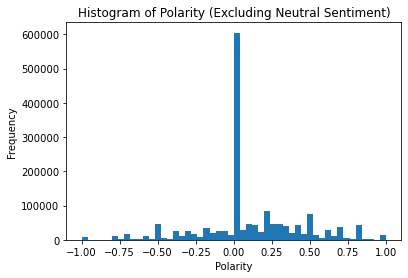

In [22]:
processed_data = df.select("polarity").toPandas()

plt.hist(processed_data["polarity"], bins=50)
plt.xlabel("Polarity")
plt.ylabel("Frequency")
plt.title("Histogram of Polarity (Excluding Neutral Sentiment)")
plt.show()

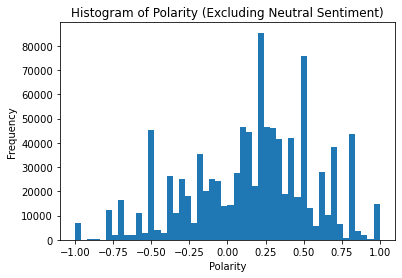

In [23]:
processed_data = df.filter(df["polarity"] != 0.0).select("polarity").toPandas()

plt.hist(processed_data["polarity"], bins=50)
plt.xlabel("Polarity")
plt.ylabel("Frequency")
plt.title("Histogram of Polarity (Excluding Neutral Sentiment)")
plt.show()

In [24]:
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")


from pyspark.sql.functions import to_timestamp

timestamp = to_timestamp("Mon Nov 05 20:40:00 2023 PST", "EEE MMM dd HH:mm:ss yyyy Z")


In [25]:
from pyspark.sql import functions as F
from pyspark.sql.types import TimestampType



# Convert the date column to a Timestamp type.
df = df.withColumn("new_date", F.to_timestamp(df["date"], "EEE MMM dd HH:mm:ss z yyyy"))

# Cast the new_date column to a TimestampType.
df = df.withColumn("new_date", F.col("new_date").cast(TimestampType()))

# Display the DataFrame.
df.show()


2023-11-11 13:40:48,665 WARN window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+------+--------------------+--------------------+----------+--------------------+-----------+------------+-------------------+
|number|                date|        text_cleaned|row_number|           sentiment|   polarity|subjectivity|           new_date|
+------+--------------------+--------------------+----------+--------------------+-----------+------------+-------------------+
|  8575|Fri Apr 17 20:30:...|working songg aun...|         1|{-0.24583334, 0.5...|-0.24583334|   0.5708333|2009-04-18 04:30:31|
|  8576|Fri Apr 17 20:30:...|    sleep 4 30am 8am|         2|          {0.0, 0.0}|        0.0|         0.0|2009-04-18 04:30:34|
|  8577|Fri Apr 17 20:30:...|wishing could coa...|         3|         {-0.3, 0.4}|       -0.3|         0.4|2009-04-18 04:30:38|
|  8578|Fri Apr 17 20:30:...|well lilwo tough ...|         4|{-0.5515873, 0.84...| -0.5515873|   0.8452381|2009-04-18 04:30:39|
|  8579|Fri Apr 17 20:30:...|taking much neede...|         5|{-0.125, 0.41666666}|     -0.125|  0.416666

In [26]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.types import TimestampType

# SparkSession oluştur
spark = SparkSession.builder.appName("TwitterDataProcessing").getOrCreate()


# 'new_date' sütununu tarih formatına çevir
df = df.withColumn("time", col("new_date").cast(TimestampType()))

# Gereksiz sütunları çıkar
df = df.select("number", "time", "polarity")

# 'new_date' sütununu çıkar
df = df.drop("new_date")

# 'time' sütununa göre sırala
df = df.orderBy("time")

# Sonuçları göster
df.show(truncate=False)


+------+-------------------+-----------+
|number|time               |polarity   |
+------+-------------------+-----------+
|0     |2009-04-07 06:19:45|0.2        |
|1     |2009-04-07 06:19:49|0.0        |
|2     |2009-04-07 06:19:53|0.5        |
|3     |2009-04-07 06:19:57|0.2        |
|4     |2009-04-07 06:19:57|-0.625     |
|5     |2009-04-07 06:20:00|0.2        |
|7     |2009-04-07 06:20:03|0.34166667 |
|6     |2009-04-07 06:20:03|0.0        |
|8     |2009-04-07 06:20:05|0.0        |
|9     |2009-04-07 06:20:09|0.0        |
|10    |2009-04-07 06:20:16|-0.21428572|
|11    |2009-04-07 06:20:17|0.0        |
|13    |2009-04-07 06:20:19|0.0        |
|12    |2009-04-07 06:20:19|0.0        |
|15    |2009-04-07 06:20:20|0.0        |
|14    |2009-04-07 06:20:20|0.225      |
|16    |2009-04-07 06:20:22|0.0        |
|17    |2009-04-07 06:20:25|0.0        |
|18    |2009-04-07 06:20:31|0.5        |
|19    |2009-04-07 06:20:34|0.0        |
+------+-------------------+-----------+
only showing top

In [29]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.types import TimestampType
import plotly.express as px
import dash
from dash import dcc, html

# SparkSession oluştur
spark = SparkSession.builder.appName("TwitterDataProcessing").getOrCreate()


# Plotly Express kullanarak çizgi grafiği oluştur
fig = px.line(df.toPandas(), x="time", y="polarity", title="Time vs Polarity")

# Dash uygulamasını başlat
app = dash.Dash(__name__)

# Dashboard layout
app.layout = html.Div(children=[
    dcc.Graph(id='line-chart', figure=fig)
])

# Uygulamayı çalıştır
if __name__ == '__main__':
    app.run_server(debug=True)


In [27]:
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")
spark.conf.set("spark.sql.session.timeZone", "UTC")


+-------+------+
|   week| count|
+-------+------+
|2009-15| 20671|
|2009-16| 17154|
|2009-17| 62200|
|2009-18| 31096|
|2009-19| 54868|
|2009-20| 63480|
|2009-21|126975|
|2009-22|176668|
|2009-23|483516|
|2009-24|130459|
|2009-25|347232|
|2009-26| 85681|
+-------+------+



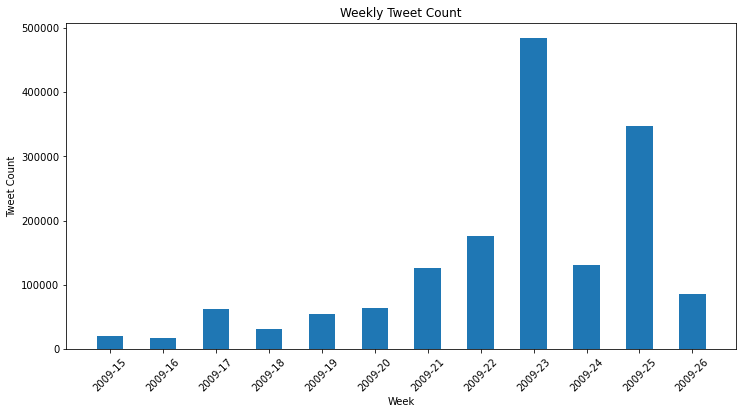

In [28]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import date_format

# 1-Week Analysis
weekly_data = df.groupBy(date_format("time", "yyyy-ww")).count()
weekly_data = weekly_data.withColumnRenamed("date_format(time, yyyy-ww)", "week")
weekly_data = weekly_data.orderBy("week", ascending=True)
weekly_data.show()

# Get the result and visualize it
weekly_data_pd = weekly_data.toPandas()

# Plot for 1-Week Time Series
plt.figure(figsize=(12, 6))
plt.bar(weekly_data_pd["week"], weekly_data_pd["count"], width=0.5)
plt.title("Weekly Tweet Count")
plt.xlabel("Week")
plt.ylabel("Tweet Count")
plt.xticks(rotation=45)
plt.show()


#  CALISAN KISIM

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, window
from pyspark.sql.window import Window

# Spark oturumu oluştur
spark = SparkSession.builder.appName("TimeSeriesAnalysis").getOrCreate()

# Tarih sütununu zaman damgasına dönüştür

df = df.withColumn("new_date", col("new_date").cast("timestamp"))

# 1 haftalık zaman serisi
weekly_series = df.groupBy(window("new_date", "1 week")).count()
weekly_series.show(truncate=False)

# 1 aylık zaman serisi (30 gün olarak hesaplanır)
monthly_series = df.groupBy(window("new_date", "30 days")).count()
monthly_series.show(truncate=False)

# 3 aylık zaman serisi (90 gün olarak hesaplanır)
quarterly_series = df.groupBy(window("new_date", "90 days")).count()
quarterly_series.show(truncate=False)

# Spark oturumunu kapat
spark.stop()


import dash
from dash import dcc, html
import plotly.express as px
import pandas as pd

from pyspark.sql import SparkSession

# SparkSession oluştur
spark = SparkSession.builder.appName("example").getOrCreate()


# Spark DataFrame'ini Pandas DataFrame'e dönüştür
df_pandas = df.toPandas()

# Dash uygulamasını oluştur
app = dash.Dash(__name__)

# Dashboard düzenini oluştur
app.layout = html.Div(children=[
    html.H1(children='Sentiment Analysis Dashboard'),

    dcc.Graph(
        id='sentiment-graph',
        figure=px.line(df_pandas, x='new_date', y='polarity', title='Polarity Change Over Time')
    )
])

# Uygulamayı çalıştır
if __name__ == '__main__':
    app.run_server(debug=True)
